
## Sustitución por valores al final de la distribución 

En la sección anterior, sustituimos valores ausentes por valores constantes. Sin embargo, determinar el valor arbitrario es un proceso laborioso y manual. Este proceso se puede automatizar seleccionando un valor al final de la distribución.

### Cómo se seleccionan los valores al final de la distribución?

- Si la variable está normalmente distribuida, podemos usar el promedio más o menos 3 veces la desviación estandard.
- Si la variable está sesgada, pueden usar la regla de proximidad inter-cuantil IQR

Estas técnicas las aprendimos en la sección 3, en la clase de "Outliers" o Valores Extremos

- Podemos también seleccionar el valor min/max y multiplicarlo por cierta número de veces, como 2 o 3.

### Cuáles variables podemos sustituir con valores arbitrarios?

Este método es apropiado para variables numéricas.


### Condiciones

- Los datos no faltan de forma aleatoria

Si este es el caso, queremos comunicar que estos valores nulos son diferentes y por lo tanto los reemplazamos con un valor arbitrario y no con la media/mediana que representan los valores más comunes.


### Ventajas

- Fácil de implementar
- Forma rápida de obtener conjuntos completos de datos
- Puede ser integrado en producción (durante el despliegue del modelo)
- Captura la importancia de la 'ausencia' (si existe)

### Limitaciones

- Distorción de la distribución original de la variable
- Distorción de la varianza original
- Distorción de la covarianza con las otras variables en los datos.
- Esta técnica puede encubrir los valores extremos verdaderos que se encuentan al final de la distribución.

### Nota Final

Este metodo no es muy común en las competenticas de ciencia de datos, sin embargo es usado ampliamente en companías financieras. Cuando se captura la historia financiera de clientes, para no asumir que los valores faltan aleatoriamente, los datos ausentes son reemplazados por un valor al final de la distribución.

Pueden ver nuestra charla en [talk at PyData London in 2017](https://www.youtube.com/watch?v=KHGGlozsRtA) donde se presenta un ejemplo de ingeniería de variables en Finanzas.

## En este demo:

Vamos a aprender como sustituir valores nulos con valores arbitrarios utilizando pandas y Ames House Price y Titanic Datasets.

- Para bajar los datos, por favor referirse a la clase en **Datasets** en la  **Sección 1** del curso.



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
# Titanic Dataset con unas variables para el demo

data = pd.read_csv('../titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# porcentaje de NA o valores nulos
data.isnull().mean()

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

### Para tener en cuenta

Sustitución se debe hacer en el segmento usado para entrenar el modelo, y luego deber ser propagado en el segmento de prueba. Para esta técnica de sustitución, los valores seleccionados se tomarán SOLAMENTE mirando la distribucíon de la variable en el segmento de entrenamiento. Luego el valor seleccionadom se usa para reemplazar los valores nulos o NA en ambos segmentos el de entrenamiento y prueba.

In [4]:
# Separemos en segmentos para entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 2), (393, 2))

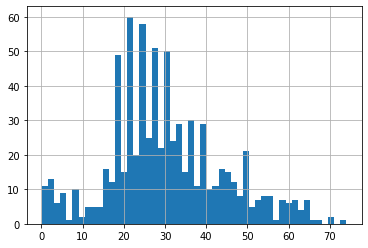

In [5]:
# distribución de la variable age
X_train.age.hist(bins=50)

In [6]:
# creemos una función para sustituir los valores faltantes
# con un valor extremo
# la función toma como argumentos:
# dataframe, variable, y el valor de arbitrario para la sustitución
# retorna la variable con los valores sustituidos

def impute_na(df, variable, value):

    return df[variable].fillna(value)

In [7]:
# extremo final de la distribución:

# Age parece tener distribución Gaussiana, usaremos
# el promedio y la desviación estandar para sustituir valores

X_train.age.mean() + 3 * X_train.age.std()

72.03416424092518

In [8]:
# sustituir los NA con los valores calculados anteriormente

X_train['age_imputed'] = impute_na(X_train, 'age',
                                   X_train.age.mean() + 3 * X_train.age.std())

X_train.head(15)

,age,fare,age_imputed
501,13.0,19.5000,13.000000
588,4.0,23.0000,4.000000
402,30.0,13.8583,30.000000
1193,NaN,7.7250,72.034164
686,22.0,7.7250,22.000000
971,NaN,7.8792,72.034164
117,30.0,56.9292,30.000000
540,2.0,26.0000,2.000000
294,49.0,110.8833,49.000000
261,35.0,26.2875,35.000000


las filas con valores nulos (NaN) in Age, fueron reemplazadas con el valor 72.034164

In [9]:
# podemos ver el cambio el la varianza con el cambio al final de la 
# distribución end of tail imputation

# esto es de esperarse, porque el porcentaje de valores ausentes 
# es relativamente grande en age, ~20%

print('Varianza variable original: ', X_train['age'].var())
print('Varianza luego de sustitución por media mas 3*std: ', X_train['age_imputed'].var())

Varianza variable original:  194.16304666581863
Varianza luego de sustitución por media mas 3*std:  427.39198372523526


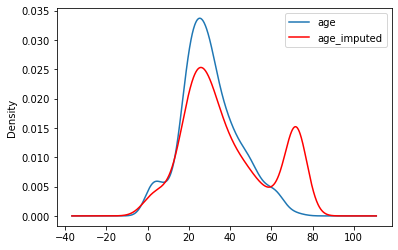

In [10]:
# Comparemos distribuciones

# podemos ver que la distribución ha cambiado con mas
# valores acumulados al final de la escala

fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original de la variable
X_train['age'].plot(kind='kde', ax=ax)

# distribución variable sustituida con  media mas 3*std
X_train['age_imputed'].plot(kind='kde', ax=ax, color='red')

# etiquetas
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')



Al igual que en la sustitución por valores arbitrarios, la sustitución por valores al final de la distribución distorciona la distribución original de la variables y como es de esperarse, la variable transformada tiene mas valores alrededor del final de la misma, ya que la variable Age tiene más valores alrededor de este punto. 

**Es esto importante?**

Depende del algoritmo de machine learning seleccionado para constriuir el modelo.
Los modelos lineales asumen que las variables están normalmente distribuidas. La sustitución por valores arbitrarios puede distorcionar la distribución normal original si el porcentaje de valores ausentes es alto y por lo tanto afectar el desempeno del modelo lineal.


Por el contrario, esta técnica funciona muy bien para los algoritmos basados en árboles.



In [11]:
# esta técnica tambien puede afectar la relación de las variables
# con las restantes en los datos,

X_train[['fare', 'age', 'age_imputed']].cov()

,fare,age,age_imputed
fare,2248.326729,136.176223,19.647139
age,136.176223,194.163047,194.163047
age_imputed,19.647139,194.163047,427.391984


Se puede observar que la covarianza entre Age y Fare cambió luego de la sustitución

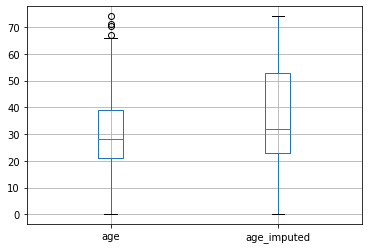

In [12]:
# Finalmente, la sustitución puede encubrir los valores extremos

# Gráfico de caja
X_train[['age', 'age_imputed']].boxplot()

Los valores extremos parecen haber desaparecido!!!!

## House Prices Dataset

Repitamos rápidamente el mismo ejercicio con el House Prices dataset; este tiene variables con pocos o bastantes valores nulos, porlo tanto podemos comparar el efecto de la sustitución en ambos escenarios.

In [13]:
# Vamos a usar las siguientes variables
# 3 de las cuales tienen valores nulos


cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [14]:
# House Prices dataset

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [15]:
# en la siguiente lista (list comprehension), vamos a iterar sobre 
#las columnas en los datos y seleccionar aquellas con valores faltantes

[var for var in data.columns if data[var].isnull().sum()>0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [16]:
# porcentaje de valores nulos

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

In [17]:
# separemos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

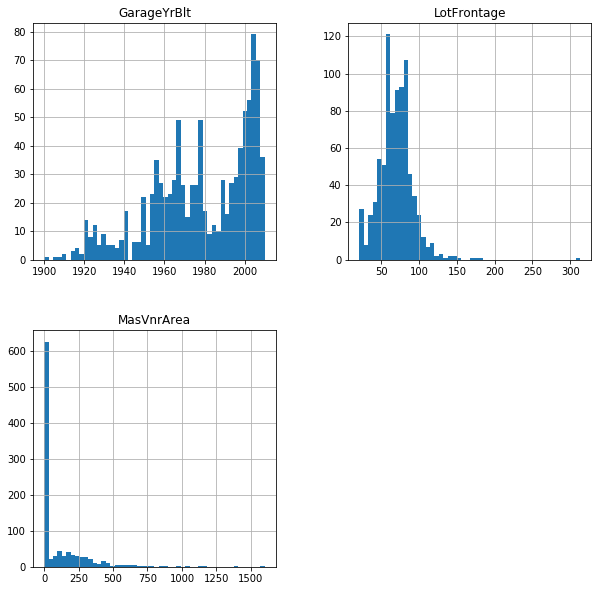

In [18]:
# distribuciones de las variables

X_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=50, figsize=(10,10))
plt.show()

In [19]:
# las variables estan normalmente distribuidas

# sustituyamos los valores nulos con la regla de proximidad del rango inter-cuantil
# como vimos en la clase de valores extremos en la sección 3

# rango inter-cuantil IQR
IQR = X_train['LotFrontage'].quantile(0.75) - X_train['LotFrontage'].quantile(
    0.25)

# límite superior
extreme_value = X_train['LotFrontage'].quantile(0.75) + 3 * IQR

extreme_value

146.0

In [20]:
# sustituir valores nulos con los valores extremos

X_train.loc[:,'LotFrontage_imputed'] = impute_na(X_train, 'LotFrontage', extreme_value)
X_test.loc[:,'LotFrontage_imputed'] = impute_na(X_test, 'LotFrontage', extreme_value)

/Users/natisangarita/python/courses/feml/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/natisangarita/python/courses/feml/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
# repitamos para la variable MasVnrArea

# rango inter-cuantil IQR
IQR = X_train['MasVnrArea'].quantile(0.75) - X_train['MasVnrArea'].quantile(
    0.25)

# límite superior
extreme_value = X_train['MasVnrArea'].quantile(0.75) + 3 * IQR

extreme_value

680.0

In [22]:
# sustituir valores nulos con los valores extremos

X_train.loc[:,'MasVnrArea_imputed'] = impute_na(X_train, 'MasVnrArea', extreme_value)
X_test.loc[:,'MasVnrArea_imputed'] = impute_na(X_test, 'MasVnrArea', extreme_value)

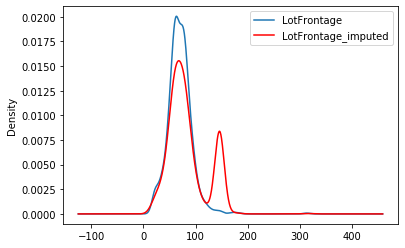

In [23]:
# evaluemos el efecto de la sustitución en las distribuciones

# Más valores se acumular hacia la mediana en la 
# distribución de LotFrontAge


fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# variable sustituida 
X_train['LotFrontage_imputed'].plot(kind='kde', ax=ax, color='red')

# etiquetas
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')



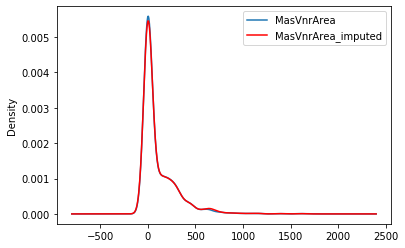

In [24]:
# evaluemos el efecto de la sustitución en las distribuciones

# MasVnrArea tienen solo unos pocos valores nulos, por lo tanto
# el cambio en la distribución es menos dramático. Menos cuand el valor arbitrario es 2999
# como vimos en el notebook anterior

fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# variable sustituida con 2999
X_train['MasVnrArea_imputed'].plot(kind='kde', ax=ax, color='red')

# etiquetas
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

Podemos observar de las gráficas anteriores que la distribución de LotFrontAge cambió dramáticamente, a diferencia de MasVnrArea. Esto se debe a que el % de valores nulos en la segunda variable es pequeño.

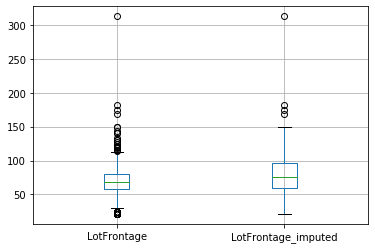

In [25]:
# tambien vemos que hay menos valores extremos después de la sustitución
X_train[['LotFrontage', 'LotFrontage_imputed']].boxplot()

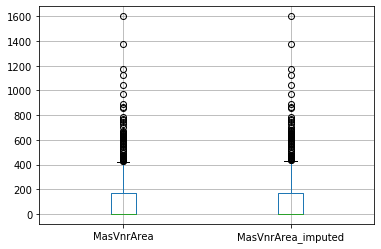

In [26]:
# sin embargo, los valores extremos no se afectan para la variable
# MasVnrArea

X_train[['MasVnrArea', 'MasVnrArea_imputed']].boxplot()

In [27]:
# Igualmente podemos ver el efecto de la sustitución
# en la varianza

# Para LotFrontAge hay un cambio significativo ya que el porcetaje
# de valores nulos es alto~20%

print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after imputation: ', X_train['LotFrontage_imputed'].var())

Original Variance:  532.5872021885677
Variance after imputation:  1313.0936747097642


In [28]:
# En MasnVnrArea, el cambio en la varianza no es considerable
# es importante resaltar que el efecto es mucho mas pequeño 
# que cuando se uso el valor 2999 para la sustitución de los valores nulos

print('Varianza original: ', X_train['MasVnrArea'].var())
print('Varianza despues de sustitución: ', X_train['MasVnrArea_imputed'].var())



Varianza original:  32983.53871003956
Varianza despues de sustitución:  34441.331260745486


In [29]:
# Exploremos la covarianza:
# tómate el tiempo de comparar los valores en la tabla

X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_imputed,MasVnrArea_imputed
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,6.934872e+02
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,3.425501,1.035991e+02
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,639.100679,3.298354e+04
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,-850.739199,7.680598e+03
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,2308.792907,2.473980e+04
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,3142.724647,2.055453e+04
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,3723.250100,3.541558e+04
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,26.484608,1.274750e+03
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,542.437312,3.088048e+03
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,578446.035624,6.872641e+06


**Es todo por este demo. Esperemos lo hayan disfrutado.
Nos vemos en el siguiente!! **